# Bayesian methods for machine learning - Week 1

In [151]:
from graphviz import Digraph

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

import scipy

import matplotlib.pyplot as plt

import numpy as np

## Linear regression example

### Multivariate normal recap

Given a multivariate Normal distribution with vector mean $\mu$ and covariance matrix $\Sigma$, its probability density function is defined as:

$$
\mathcal{N}(x|\mu, \Sigma) = \frac{1}{\sqrt{|2\pi \Sigma |}} \exp \left[-\frac{1}{2} (x - \mu)^{\top} \Sigma^{-1} (x - \mu) \right] = C \exp \left[-\frac{1}{2} (x - \mu)^{\top} \Sigma^{-1} (x - \mu) \right]
$$

Where we have wrapped the normalization constant into $C$.

Note that, when the number of variables $D$ increases, $\Sigma$ can be expensive to store. There are several ways to represent it:

- **Full**. $\frac{D(D+1)}{D}$ parameters.
- **Diagonal**. All but values in the diagonal are 0. $D$ parameters.
- **Spherical**. It is the product of a constant and the identity matrix. Single parameter.

### Presenting problem

We want to solve the Least Squares problem:
    
$$
L(w) = \sum^N_{i=0} (\hat{y}_i - X_i)^2 = \sum^N_{i=0} (w^{\top}X_i - y_i)^2 = ||w^{\top}X - y||^2
$$

To do so, we want to find the weights that minimize the loss:

$$
\hat{w} = \underset{w}{\mathrm{argmin}} \ L(w)
$$

Where:

- $w \in \mathcal{R}^{m \times 1}$
- $X \in \mathcal{R}^{m \times n}$
- $y \in \mathcal{R}^{1 \times n}$

### Bayesian perspective

Let's address from a Bayesian perspective:

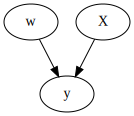

In [8]:
lr = Digraph()
lr.node('w')
lr.node('y')
lr.node('X')
lr.edges(['wy', 'Xy'])
lr

We can define the probability of the targets and the weights given the data as:
    
$$
\begin{align*}
P(w, y|X) & = \frac{P(w, y, X)}{P(X)} \\
          & = \frac{P(y|w, X)P(X)P(w)}{P(X)} \\
          & = P(y|w, X)P(w)
\end{align*}
$$

Given joint probability is $P(w, X, y) = P(y|w, X)P(X)P(w)$. Now we define these two distributions:

Let's assume normality in the distribution of the target given weights and data:

$$
P(y|X, w) = N(y|w^{\top}X, \sigma^2I)
$$

So mean is the dot product of the weights and the data and we use an spherical representation for the matrix $\Sigma$ using constant $\sigma^2$.

Probability of the weights are also defined as a gaussian centered at zero and with a spherical representation of $\Sigma$ using constant $\gamma^2$:

$$
P(w) = \mathcal{N}(w|0, \gamma^2 I)
$$


## Training linear regression

Let's start by computing the posterior probability of the weights, using the definition of conditional probability:

$$
P(w|y, X) = \frac{P(w, y|X)}{P(y|X)}
$$

**Derivation**

Note that, this can be derived by the following definition:

$$
P(a|b,c) = \frac{P(a,b|c)}{P(b|c)}
$$

As:

$$
\begin{align*}
P(a, b|c) & = \frac{P(a, b, c)}{P(c)} \rightarrow P(a,b,c) = P(a, b|c)P(c) \\
P(b|c) & = \frac{P(b, c)}{P(c)} \rightarrow P(b,c) = P(b|c)P(c)
\end{align*}
$$

Therefore:

$$
\begin{align*}
P(a|b,c) & = \frac{P(a,b,c)}{P(b,c)} \\
         & = \frac{P(a, b|c)P(c)}{P(b|c)P(c)} \\
         & = \frac{P(a, b|c)}{P(b|c)}
\end{align*}
$$


### Maximum a posteriori

We want to compute, rather than the whole posterior distribution, the parameters $\hat{w}$ at which the posterior has the maximum value:

$$
\hat{w} = \underset{w}{\mathrm{argmax}} \frac{P(w, y|X)}{P(y|X)} \propto P(w, y|X)
$$

As the denominator does not depend on weights, maximizing with respect of the posterior is equivalent to maximizing with respect to the numerator. As we have seen above, we can replace the numerator using the definition of conditional probability and the joint probability distribution:

$$
\hat{w} = \underset{w}{\mathrm{argmax}} P(y|w, X)P(w)
$$

Maximizing this is equivalent to maximizing its logarithm (as it will ease the optimization problem):

$$
\begin{align*}
\hat{w} & = \underset{w}{\mathrm{argmax}} \ \log P(y|w, X)P(w) \\
        & = \underset{w}{\mathrm{argmax}} \ \log P(y|w, X) + \log P(w)
\end{align*}
$$

Then, we have to optimize with respect to the likelihood of both distributions:

$$
\begin{align*}
\log P(y|w, X) & = \log \left[ \frac{1}{\sqrt{|2\pi \sigma^2I|}} \exp \left[-\frac{1}{2} (y - w^{\top}X)^{\top} (\sigma^2I)^{-1} (x - w^{\top}X) \right] \right] \\
               & = \log \left[ C_1 \exp \left[-\frac{1}{2} (y - w^{\top}X)^{\top} [\sigma^2I]^{-1} (y - w^{\top}X) \right] \right] \\
\end{align*}
$$

$$
\begin{align*}
\log P(w) & = \log \left[-\frac{1}{\sqrt{|2\pi \gamma^2I |}} \exp \left[-\frac{1}{2} w^{\top} (\gamma^2I)^{-1} w\right]  \right] \\
          & = \log \left[ C_2 \exp \left[-\frac{1}{2} w^{\top} (\gamma^2I)^{-1} w \right] \right]
\end{align*}
$$

We can ignore the constants, as they do not depend on $w$. Moreover, we can remove the $\log \exp$ expressions, as they generate the identify function:

$$
\begin{align*}
\log P(y|w, X) \propto& -\frac{1}{2} (y - w^{\top}X)^{\top} [\sigma^2I]^{-1} (y - w^{\top}X)  \\
\log P(w) \propto& -\frac{1}{2} w^{\top} (\gamma^2I)^{-1} w
\end{align*}
$$

As the inversion of a diagonal matrix corresponds to the reciprocals of its elements, we can rewrite this so:

$$
\begin{align*}
\log P(y|w, X) \propto& -\frac{1}{2\sigma^2} (y - w^{\top}X)^{\top} (y - w^{\top}X) \\
\log P(w) \propto& -\frac{1}{2\gamma^2} w^{\top} w
\end{align*}
$$

We are left with the follow optimization problem:

$$
\begin{align*}
\hat{w} & = \underset{w}{\mathrm{argmax}} \log P(y|w, X) + log P(w) \\
        & = \underset{w}{\mathrm{argmax}} -\frac{1}{2\sigma^2} (y - w^{\top}X)^{\top} (y - w^{\top}X) -\frac{1}{2\gamma^2} w^{\top} w
\end{align*}
$$

If we multiply by $-2\sigma²$, wecan re-organize the equation and convert the problem into a minimization problem, so:

$$
\begin{align*}
\hat{w} & = \underset{w}{\mathrm{argmin}} (y - w^{\top}X)^{\top} (y - w^{\top}X) + \frac{\sigma^2}{\gamma^2} w^{\top} w \\
        & = \underset{w}{\mathrm{argmin}} \Vert y - w^{\top}X \Vert_2^2 + \lambda \Vert w \Vert_2^2 
\end{align*}
$$

Note that, in the end, we get to the minimization of the least squares and a L2 regularization term.

### Solution to optimization problem

In order to find solution, we must find the roots of the derivative:

$$
\frac{\partial \hat{w}}{\partial w} = \frac{\partial}{\partial{w}} \left((y - w^{\top} X)^{\top}(y - w^{\top} X) + \lambda(w^{\top}w)\right) \\
$$

As $\frac{\partial}{\partial{x}} {X^{\top}X} = 2X \frac{\partial{X}}{\partial{x}}$, we can write:

$$
\begin{align*}
\frac{\partial \hat{w}}{\partial w} & = 2(y - w^{\top}X)(-X)^{\top} + 2\lambda w^{\top} \\
                                    & = -2yX^{\top} + 2w^{\top} XX^{\top} + 2\lambda w^{\top}
\end{align*}
$$

$$
\begin{align*}
-2Xy^{\top} + 2w^{\top} XX^{\top} + 2 \lambda w^{\top} & = 0 \\
w^{\top} & = (XX^{\top} + 2\sigma^2I)^{-1} y X^{\top}
\end{align*}
$$

Let's find the roots of the derivative using the normal equation:

$$
\begin{align*}
-2Xy^{\top} + 2w^{\top} XX^{\top} + 2 \lambda w^{\top} & = 0 \\
w^{\top} XX^{\top} + \lambda w^{\top} & = Xy^{\top} \\
w^{\top} & = (XX^{\top} + \lambda I)^{-1} X y^{\top}
\end{align*}
$$

## Hands-on

Let's first set the parameter for the covariance matrices of the distributions.

In [18]:
sigma_sq = 1
gamma_sq = 0.5

Let's load the Boston UCI regression dataset.

In [27]:
boston_x, boston_y = load_boston(return_X_y=True)
boston_x = boston_x.T
boston_y = np.expand_dims(boston_Y, axis=0)

Let's compute the analytical value for the MAP:

In [64]:
def map_weights(x: np.ndarray,
                y: np.ndarray,
                sigma_squared: float,
                gamma_squared: float) -> np.ndarray:
    X_dot = np.dot(x, x.T)
    lambda_value = sigma_squared/gamma_squared
    inverse = np.linalg.inv(X_dot + np.identity(X_dot.shape[0]) * lambda_value)
    return np.dot(np.dot(inverse, x), y.T).T

w = map_weights(boston_x, boston_y, sigma_sq, gamma_sq)

Let's plot predictions vs groundtruth using a subset of the data.

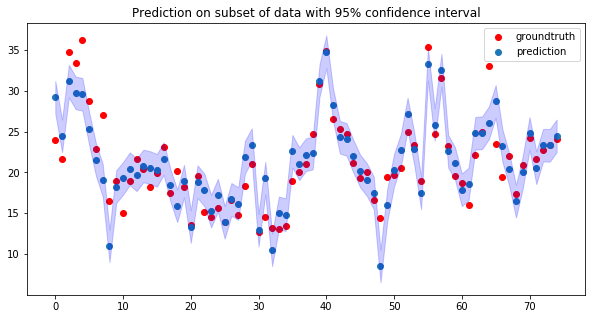

In [149]:
n_subset = 75
y_pred = np.squeeze(np.dot(w, boston_x))

plt.figure(figsize=(10, 5))
ax = plt.gca()

ax.scatter(x=range(n_subset),
           y=boston_y[0][:n_subset],
           label='groundtruth',
           color='r')
ax.scatter(x=range(n_subset),
           y=y_pred[:n_subset],
           label='prediction')

# Fill ~95% confidence interval for prediction
sigma = np.sqrt(sigma_sq)
ax.fill_between(x=range(n_subset),
                y1=y_pred[:n_subset] - 2*sigma,
                y2=y_pred[:n_subset] + 2*sigma,
                color='b',
                alpha=0.20)

plt.title('Prediction on subset of data with 95% confidence interval')
plt.legend()

## References

- https://towardsdatascience.com/ridge-regularization-on-linear-regression-and-deep-learning-a32cd9dc5a78  
- https://ocw.tudelft.nl/course-lectures/least-squares-analytical-solution/
- http://www.gatsby.ucl.ac.uk/teaching/courses/sntn/sntn-2017/resources/Matrix_derivatives_cribsheet.pdf